In [73]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim import Adam
import nibabel as nib
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

In [74]:
import os
images = './new_dataset/new_dataset/split/train'
masks = './new_dataset/new_dataset/split/train'

if os.path.exists(images) and os.path.exists(masks) :
    print('Yes')

Yes


In [75]:
import os
from PIL import Image
import numpy as np
import cv2
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, transform_gray=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.transform_gray = transform_gray
        
        self.images = self.load_files(self.image_dir)
        self.masks = self.load_files(self.mask_dir)

        # Ensure that we only keep files where the name matches
        self.images, self.masks = self.match_files(self.images, self.masks)

        # Sanity check: Ensure the number of images and masks is the same
        assert len(self.images) == len(self.masks), "Mismatch between image and mask counts!"

    def load_files(self, directory):
        """ Load all image files from the directory and its subdirectories. """
        files = []
        for subdir, _, filenames in os.walk(directory):
            for filename in filenames:
                if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other extensions if needed
                    files.append(os.path.join(subdir, filename))
        return sorted(files)

    def match_files(self, img_files, mask_files):
        """ Keep only the pairs of images and masks that match by filename. """
        matched_images = []
        matched_masks = []

        # Create a set of image names (without extensions) for quick lookup
        img_names = {os.path.splitext(os.path.basename(f))[0] for f in img_files}

        #print(len(img_names))  # Optional for debugging

        for mask in mask_files:
            # Get the mask name without extension, and remove '_m' suffix if present
            mask_name = os.path.splitext(os.path.basename(mask))[0].replace('_m', '')
            if mask_name in img_names:
                matched_masks.append(mask)
                # Find the corresponding image file based on the mask name
                matched_image = next((img for img in img_files if mask_name == os.path.splitext(os.path.basename(img))[0]), None)
                if matched_image:
                    matched_images.append(matched_image)
            
        return matched_images, matched_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        # Load image and mask
        try:
            image = Image.open(img_path).convert("RGB")  # Assuming images are in RGB format
            image_np = np.array(image)
            blurred_image = cv2.GaussianBlur(image_np, (11, 11), 0) 
            blurred_image = Image.fromarray(blurred_image)

            mask = Image.open(mask_path).convert("L")    # Assuming masks are in grayscale
        except Exception as e:
            print(f"Error loading image or mask: {e}")
            raise e

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform_gray(mask)

        return image, mask

In [76]:
batch_size = 4

class MinMaxNormalize:
    def __call__(self, tensor):
        # Perform min-max normalization
        min_val = tensor.min()
        max_val = tensor.max()

        # Avoid division by zero
        if max_val - min_val > 0:
            normalized_tensor = (tensor - min_val) / (max_val - min_val)
        else:
            normalized_tensor = tensor  # No normalization if min == max
        
        return normalized_tensor


# Define transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images and masks to the same size
    #transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    MinMaxNormalize()
    #transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[0.5, 0.5, 0.5])  # Normalize (for pre-trained models)
])
transform_gray = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    MinMaxNormalize()  # Mean and std for Grayscale
])

# Directories for training, validation, and test sets
train_image_dir = './new_dataset/new_dataset/split/train/image'
train_mask_dir = './new_dataset/new_dataset/split/train/mask'


valid_image_dir = './new_dataset/new_dataset/split/valid/image'
valid_mask_dir = './new_dataset/new_dataset/split/valid/mask'

test_image_dir = './new_dataset/new_dataset/split/test/image'
test_mask_dir = './new_dataset/new_dataset/split/test/mask'


# Initialize dataset and data loaders
train_dataset = SegmentationDataset(image_dir=train_image_dir, mask_dir=train_mask_dir, transform=image_transforms, transform_gray=transform_gray)
valid_dataset = SegmentationDataset(image_dir=valid_image_dir, mask_dir=valid_mask_dir, transform=image_transforms, transform_gray=transform_gray)
test_dataset = SegmentationDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=image_transforms, transform_gray=transform_gray)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [77]:
for images, masks in train_loader:
    print(f"Images shape: {images.shape}")  # Should be [batch_size, 4, H, W, D]
    print(f"Masks shape: {masks.shape}")   # Should be [batch_size, H, W, D]
    break

Images shape: torch.Size([4, 3, 224, 224])
Masks shape: torch.Size([4, 1, 224, 224])


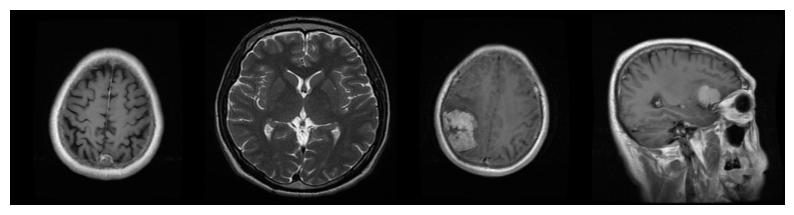

In [78]:
import matplotlib.pyplot as plt
import torchvision
import torch

# Assuming 'images' is your tensor of shape [8, 224, 224, 3]

# Convert the tensor to grayscale
# First, convert from [8, 224, 224, 3] to [8, 3, 224, 224]
# images = images.permute(0, 3, 1, 2)

# Use torchvision's Grayscale transform to convert to [8, 1, 224, 224]
gray_transform = torchvision.transforms.Grayscale(num_output_channels=1)
images_gray = torch.stack([gray_transform(img) for img in images])

# Create a grid of grayscale images
grid_img = torchvision.utils.make_grid(images_gray, nrow=4)  # Arrange in a 4x2 grid

# Convert the grid of images to numpy format for display
grid_img = grid_img.squeeze(0).permute(1, 2, 0).numpy()  # Convert to [H, W, C] for displaying with plt

# Plot the grayscale grid
plt.figure(figsize=(10, 10))
plt.imshow(grid_img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


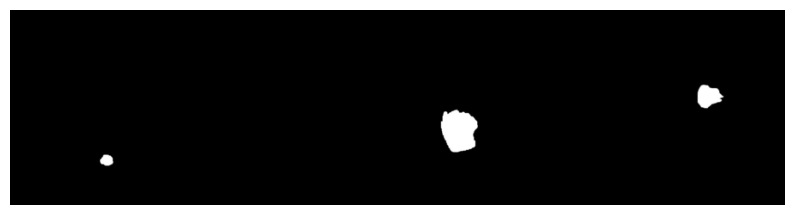

In [79]:
import matplotlib.pyplot as plt
import torchvision
import torch

# Assuming 'images' is your tensor of shape [8, 224, 224, 3]

# Convert the tensor to grayscale
# First, convert from [8, 224, 224, 3] to [8, 3, 224, 224]
# images = images.permute(0, 3, 1, 2)

# Use torchvision's Grayscale transform to convert to [8, 1, 224, 224]
gray_transform = torchvision.transforms.Grayscale(num_output_channels=1)
images_gray = torch.stack([gray_transform(img) for img in masks])

# Create a grid of grayscale images
grid_img = torchvision.utils.make_grid(images_gray, nrow=4)  # Arrange in a 4x2 grid

# Convert the grid of images to numpy format for display
grid_img = grid_img.squeeze(0).permute(1, 2, 0).numpy()  # Convert to [H, W, C] for displaying with plt

# Plot the grayscale grid
plt.figure(figsize=(10, 10))
plt.imshow(grid_img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


In [107]:
import torch
import torch.nn as nn
import torchvision.models as models

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, padding=0),
            nn.BatchNorm2d(F_int),
            nn.ReLU(inplace=True)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, padding=0),
            nn.BatchNorm2d(F_int),
            nn.ReLU(inplace=True)
        )
        self.psi = nn.Conv2d(F_int, 1, kernel_size=1, padding=0)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = torch.sigmoid(self.psi(g1 + x1))
        return x * psi

class UNetMobileNetV2Attention(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super(UNetMobileNetV2Attention, self).__init__()

        # Load MobileNetV2 pre-trained model as the encoder
        mobilenet = models.mobilenet_v2(pretrained=pretrained)

        for param in mobilenet.features.parameters():
            param.requires_grad = False

        # Extract specific layers as encoder blocks based on feature map resolutions
        self.encoder1 = mobilenet.features[0:2]  # [Batch, 16, 112, 112]
        self.encoder2 = mobilenet.features[2:4]  # [Batch, 24, 56, 56]
        self.encoder3 = mobilenet.features[4:7]  # [Batch, 32, 28, 28]
        self.encoder4 = mobilenet.features[7:14] # [Batch, 96, 14, 14]
        self.encoder5 = mobilenet.features[14:]  # [Batch, 1280, 7, 7]

        # Upsample and Attention blocks for each stage in the decoder
        self.upconv5 = self.upsample(1280, 96)
        self.att5 = AttentionGate(F_g=96, F_l=96, F_int=64)
        self.decoder5 = self.conv_block(192, 96)

        self.upconv4 = self.upsample(96, 32)
        self.att4 = AttentionGate(F_g=32, F_l=32, F_int=16)
        self.decoder4 = self.conv_block(64, 32)

        self.upconv3 = self.upsample(32, 24)
        self.att3 = AttentionGate(F_g=24, F_l=24, F_int=12)
        self.decoder3 = self.conv_block(48, 24)

        self.upconv2 = self.upsample(24, 16)
        self.att2 = AttentionGate(F_g=16, F_l=16, F_int=8)
        self.decoder2 = self.conv_block(32, 16)

        self.final_conv = nn.Conv2d(16, n_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upsample(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)

        d5 = self.upconv5(e5)
        x4_att = self.att5(d5, e4)
        d5 = self.decoder5(torch.cat([d5, x4_att], dim=1))

        d4 = self.upconv4(d5)
        x3_att = self.att4(d4, e3)
        d4 = self.decoder4(torch.cat([d4, x3_att], dim=1))

        d3 = self.upconv3(d4)
        x2_att = self.att3(d3, e2)
        d3 = self.decoder3(torch.cat([d3, x2_att], dim=1))

        d2 = self.upconv2(d3)
        x1_att = self.att2(d2, e1)
        d2 = self.decoder2(torch.cat([d2, x1_att], dim=1))

        out = self.final_conv(d2)
        output_tensor = F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=False)
        return output_tensor


In [108]:
# model = UNetMobileNetV2Attention()
# output = model(images)
# print(output.shape)

In [109]:
def dice_coeff(pred, target, smooth=1e-6):
    # Ensure predictions and targets are integers, then convert to float
    pred = pred.float()  # Convert to float for computations
    target = target.float()  # Convert to float for computations

    # Flatten tensors to calculate dice over all pixels
    pred = pred.view(-1)
    target = target.view(-1)

    # Calculate intersection and union
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return dice.item()

In [110]:
def attack(model, inputs, labels, epsilon):
    # Set requires_grad to True for the inputs
    inputs.requires_grad = True

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = Diceloss(outputs, labels)  # Use your loss function
    model.zero_grad()

    # Backward pass to get the gradients
    loss.backward()
    data_grad = inputs.grad.data

    # Generate adversarial examples
    adv_inputs = inputs + epsilon * data_grad.sign()  # Example perturbation
    adv_inputs = torch.clamp(adv_inputs, 0, 1)  # Ensure values are in valid range
    return adv_inputs

In [111]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import segmentation_models_pytorch as smp

# Initialize device, model, optimizer, and criterion
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device : {device}')
model = UNetMobileNetV2Attention().to(device)

# Parameters of unfrozen layers (layer3 in this case)
params_to_optimize = filter(lambda p: p.requires_grad, model.parameters())
# Create the optimizer with only the unfrozen parameters
optimizer = optim.Adam(params_to_optimize, lr=0.001,betas = (0.9, 0.999))
#optimizer = optim.SGD(params_to_optimize, lr=0.00001, momentum=0.9)

Diceloss = smp.losses.DiceLoss(mode='binary')  # or your chosen criterion
BCEloss = smp.losses.SoftBCEWithLogitsLoss()
MSEloss = nn.MSELoss()
Tverskyloss = smp.losses.TverskyLoss(mode='binary')


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10, min_lr=0.0001  # min_lr limits the LR
)
patience = 5  # Set patience for early stopping

# Initialize or load the best validation loss and epoch tracking
best_val_dice = 0
epochs_no_improve = 0

# Load existing model if it exists

# Load the checkpoint
checkpoint_path = './Resnet18_UNetAttention_Adversarial/BTC_newdataset_at_0.1.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # if scheduler and checkpoint['scheduler_state_dict'] is not None:
    #     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_val_loss = checkpoint['loss']
    start_epoch = checkpoint['epoch']
    print(f'Loaded model from {checkpoint_path}')
else:
    print(f'No checkpoint found at {checkpoint_path}, starting from scratch.')
    start_epoch = 0



# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'The number of parameters: {total_params}')

device : cuda
No checkpoint found at ./Resnet18_UNetAttention_Adversarial/BTC_newdataset_at_0.1.pth, starting from scratch.
The number of parameters: 3047273


In [112]:
total_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f'The number of not required grad parameters: {total_params}')

The number of not required grad parameters: 2223872


In [113]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The number of required grad parameters: {total_params}')

The number of required grad parameters: 823401


Epoch [1/50], Training Loss: 1.1556, Training Dice: 0.4853, Validation Loss: 0.0914, Validation Dice: 0.8535
Best model saved!
Epoch [2/50], Training Loss: 0.5535, Training Dice: 0.6445, Validation Loss: 0.0897, Validation Dice: 0.9049
Best model saved!
Epoch [3/50], Training Loss: 0.4408, Training Dice: 0.6985, Validation Loss: 0.1071, Validation Dice: 0.8692
Epoch [4/50], Training Loss: 0.4050, Training Dice: 0.7706, Validation Loss: 0.1279, Validation Dice: 0.8810
Epoch [5/50], Training Loss: 0.3821, Training Dice: 0.7493, Validation Loss: 0.0526, Validation Dice: 0.8865
Epoch [6/50], Training Loss: 0.3447, Training Dice: 0.7562, Validation Loss: 0.0603, Validation Dice: 0.8797
Epoch [7/50], Training Loss: 0.3392, Training Dice: 0.7759, Validation Loss: 0.0630, Validation Dice: 0.8875
Epoch [8/50], Training Loss: 0.3073, Training Dice: 0.7982, Validation Loss: 0.0700, Validation Dice: 0.8610
Epoch [9/50], Training Loss: 0.2964, Training Dice: 0.8149, Validation Loss: 0.1027, Validat

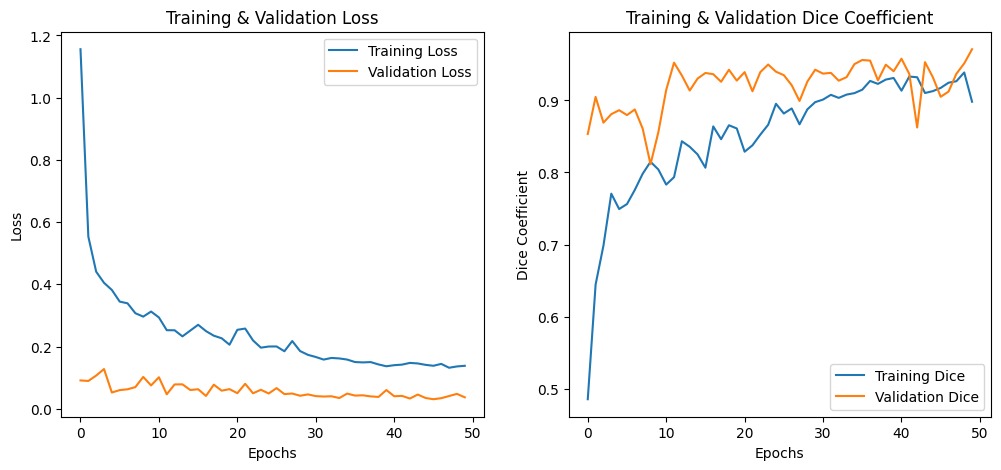

In [114]:
# Initialize lists to track losses and dice scores
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []

num_epochs = 50
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Generate adversarial examples
        adv_inputs = attack(model, inputs, labels, epsilon=0.1)

        # Forward pass
        outputs = model(inputs)

         # Forward pass through the segmentation model for adversarial inputs
        adv_outputs = model(adv_inputs)

        
        diceloss = Diceloss(outputs, labels)
        bceloss = BCEloss(outputs, labels)
        tverskyloss = Tverskyloss(outputs, labels)

        # Compute loss for adversarial outputs
        adv_diceloss = Diceloss(adv_outputs, labels)
        adv_bceloss = BCEloss(adv_outputs, labels)
        adv_tverskyloss = Tverskyloss(adv_outputs, labels)

        # Total loss: average the losses for normal and adversarial examples
        total_loss = (1 * diceloss + 0.1 * bceloss + 0.15 * tverskyloss +
                      0.3 * (adv_diceloss + adv_bceloss + adv_tverskyloss))
  
        total_loss.backward()
        optimizer.step()
        
        # Track the loss
        running_loss += total_loss.item()

        # Calculate and accumulate dice score for this batch
        labels_bin = (labels > 0.5).int()
        outputs_bin = (outputs > 0.5).int()
        batch_dice = dice_coeff(outputs_bin, labels_bin)
        running_dice += batch_dice

    # Calculate average training loss and dice score for the epoch
    avg_train_loss = running_loss / len(train_loader)
    avg_train_dice = running_dice / len(train_loader)
    
    train_losses.append(avg_train_loss)
    train_dice_scores.append(avg_train_dice)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_dice = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            
            diceloss = Diceloss(outputs, labels)
            bceloss = BCEloss(outputs, labels)
            tverskyloss = Tverskyloss(outputs, labels)

          
    
           
    
            # Total loss: average the losses for normal and adversarial examples
            total_loss = (1 * diceloss + 0.1 * bceloss + 0.15 * tverskyloss)
            
            running_val_loss += total_loss.item()

            # Calculate and accumulate dice score for this batch
            labels_bin = (labels > 0.5).int()
            outputs_bin = (outputs > 0.5).int()
            batch_val_dice = dice_coeff(outputs_bin, labels_bin)
            running_val_dice += batch_val_dice

    # Calculate average validation loss and dice score for the epoch
    avg_val_loss = running_val_loss / len(valid_loader)
    avg_val_dice = running_val_dice / len(valid_loader)

    val_losses.append(avg_val_loss)
    val_dice_scores.append(avg_val_dice)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, Training Dice: {avg_train_dice:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}')

    # Check if validation loss improved and save best model
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        epochs_no_improve = 0
        # Save the best model along with optimizer and scheduler states
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }
        torch.save(checkpoint, f'./MobileNetV2_UNetAttention_Adversarial/BTC_newdataset_at_{best_val_dice:.4f}.pth')
        print('Best model saved!')
    else:
        epochs_no_improve += 1

    # Adjust learning rate
    if scheduler:
        scheduler.step(avg_val_loss)

    # Early stopping check (optional)
    # if epochs_no_improve >= patience:
    #     print('Early stopping!')
    #     break

# Plot training/validation loss and Dice scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_dice_scores)), train_dice_scores, label='Training Dice')
plt.plot(range(len(val_dice_scores)), val_dice_scores, label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training & Validation Dice Coefficient')
plt.legend()

plt.show()

In [115]:
def non_max_suppression_fast(boxes, overlapThresh):
    """Apply Non-Maximum Suppression (NMS) to eliminate overlapping bounding boxes."""
    if len(boxes) == 0:
        return []

    # Convert to float if necessary
    boxes = boxes.astype("float")

    # Initialize the list of picked indices
    pick = []

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes and sort by bottom-right y-coordinate
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Keep looping while some indexes remain in the index list
    while len(idxs) > 0:
        # Grab the last index in the index list and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])

        # Find the smallest (x, y) coordinates for the end of the bounding box
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have overlap greater than the threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [120]:
from PIL import Image
import numpy as np
import torch

# Load the image and convert it to RGB
img_path = './Images/Te-gl_0023.jpg'
original_image = Image.open(img_path).convert('RGB').resize((224, 224))
original_image = np.array(original_image)
# blurred_image = cv2.GaussianBlur(original_image, (11, 11), 0)
# blurred_image = Image.fromarray(blurred_image) 

# Convert PIL Image to NumPy array
image_array = np.array(original_image)

image_array_norm = (image_array - image_array.min())/(image_array.max() - image_array.min())

image_array_norm = (image_array_norm * 255).astype(np.uint8)
image_array_norm = image_array_norm / 255

# Convert NumPy array to PyTorch tensor
# PyTorch expects images in the format (C, H, W), so permute dimensions accordingly
input_image = torch.tensor(image_array_norm).permute(2, 0, 1).unsqueeze(0).float()

print(f"Input Image Tensor shape: {input_image.shape}")  # Should be [3, 240, 240]

Input Image Tensor shape: torch.Size([1, 3, 224, 224])


In [121]:
checkpoint = torch.load('./MobileNetV2_UNetAttention_Adversarial/BTC_newdataset_at_0.9711.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Move model to appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Perform inference
with torch.no_grad():
    input_image = input_image.to(device)
    output = model(input_image)
    output = torch.sigmoid(output)


binary_image_uint8 min : 3.2985178207800645e-16
binary_image_uint8 max : 1.0
binary_image_uint8 shape : (224, 224)
original_image shape : 150528


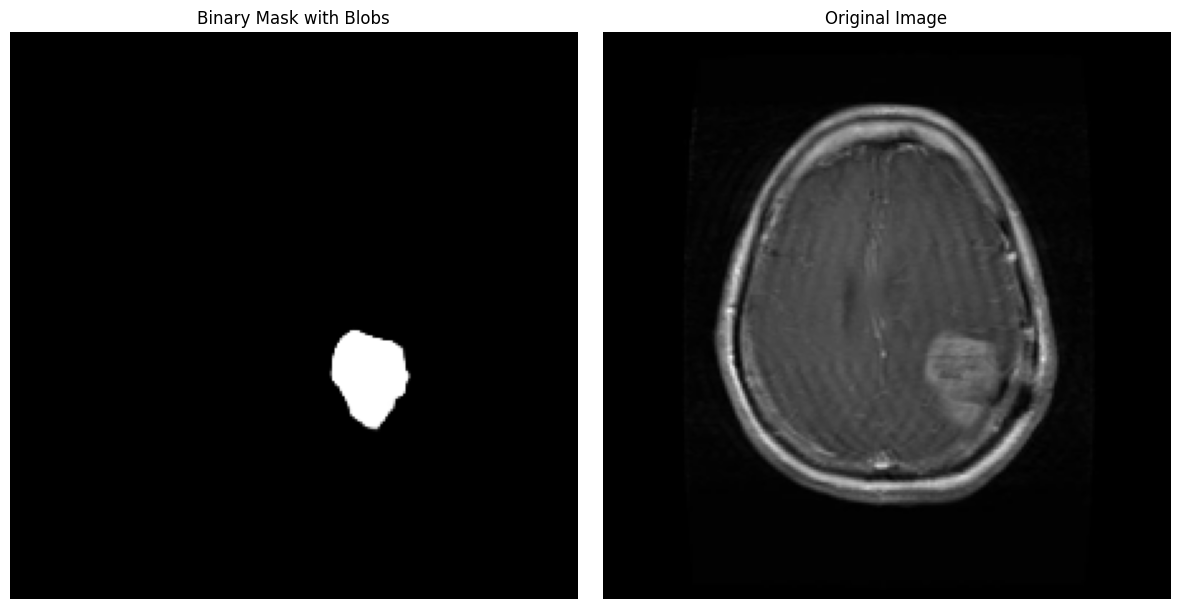

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Apply sigmoid if your model's output is logits
binary_output = (output > 0.5).int()  # Binarize the output
binary_output_np = output.squeeze().cpu().numpy()  # Remove batch dimension
binary_output_np_uint8 = (binary_output_np * 255).astype(np.uint8)

print(f'binary_image_uint8 min : {binary_output_np.min()}')
print(f'binary_image_uint8 max : {binary_output_np.max()}')
print(f'binary_image_uint8 shape : {binary_output_np.shape}')
print(f'original_image shape : {original_image.size}')

# Display both images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: Show binary mask with detected blobs
axes[0].imshow(binary_output_np, cmap='gray')
axes[0].set_title("Binary Mask with Blobs")
axes[0].axis('off')

# Right: Show original image (assuming original_image is a NumPy array in HxWxC format)
axes[1].imshow(original_image)
axes[1].set_title("Original Image")
axes[1].axis('off')

# Display the side-by-side images
plt.tight_layout()
plt.show()

In [123]:
def calculate_iou(pred, target, smooth=1e-8):
    # Ensure predictions and targets are integers, then convert to float
    pred = pred.float()  # Convert to float for computations
    target = target.float()  # Convert to float for computations

    # Flatten tensors to calculate IoU over all pixels
    pred = pred.view(-1)
    target = target.view(-1)

    # Calculate intersection and union
    intersection = (pred * target).sum()  # Sum of pixel-wise product
    union = pred.sum() + target.sum() - intersection  # Sum of all pixels minus intersection

    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)  # Add smooth to avoid division by zero

    return iou.item()

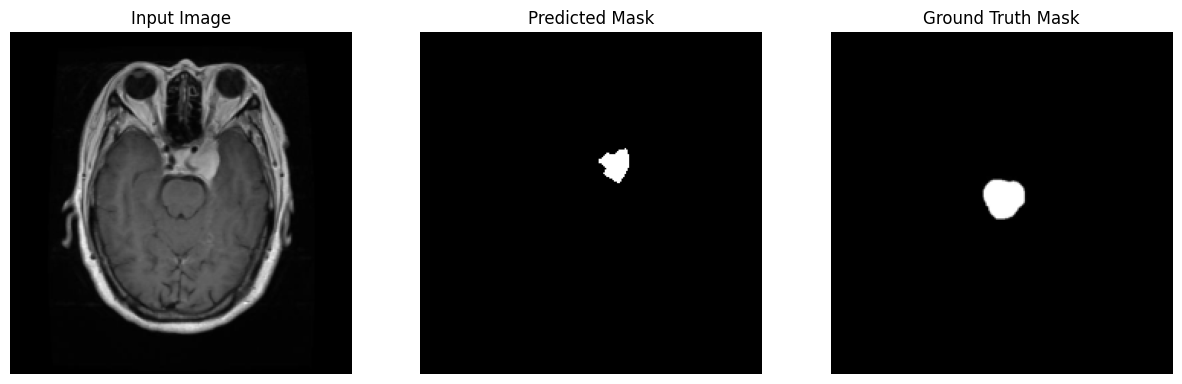

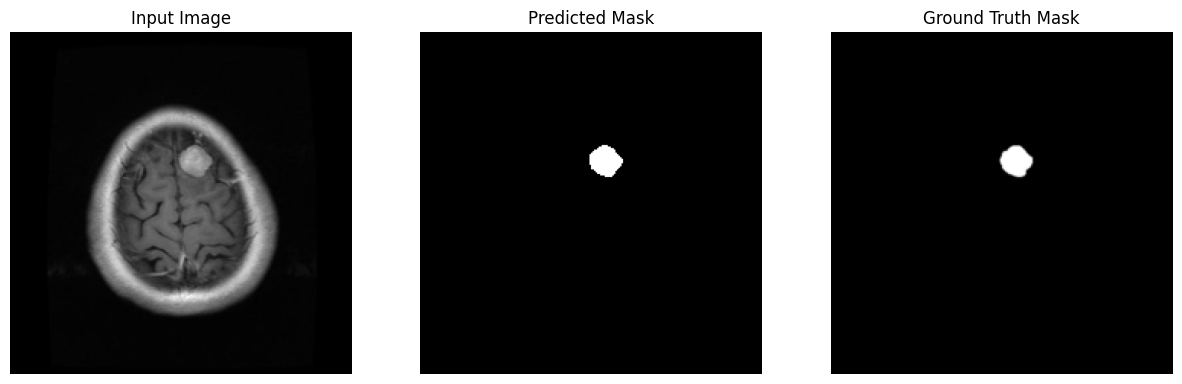

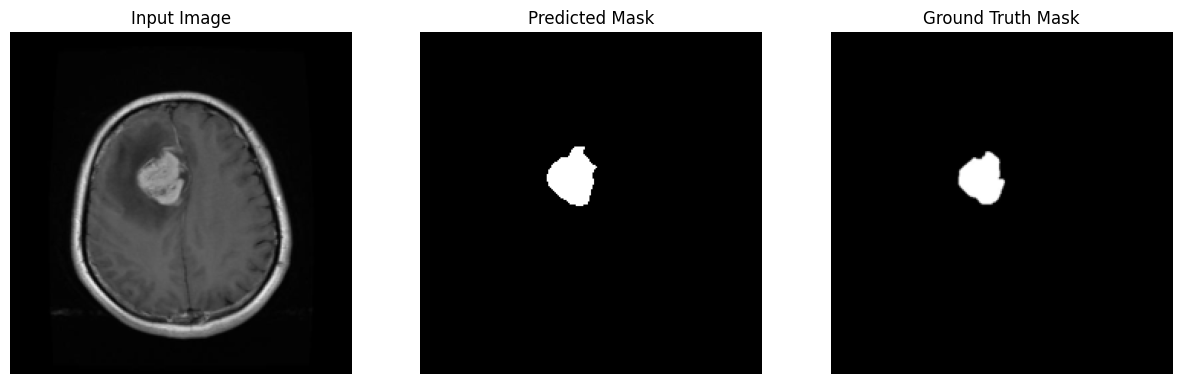

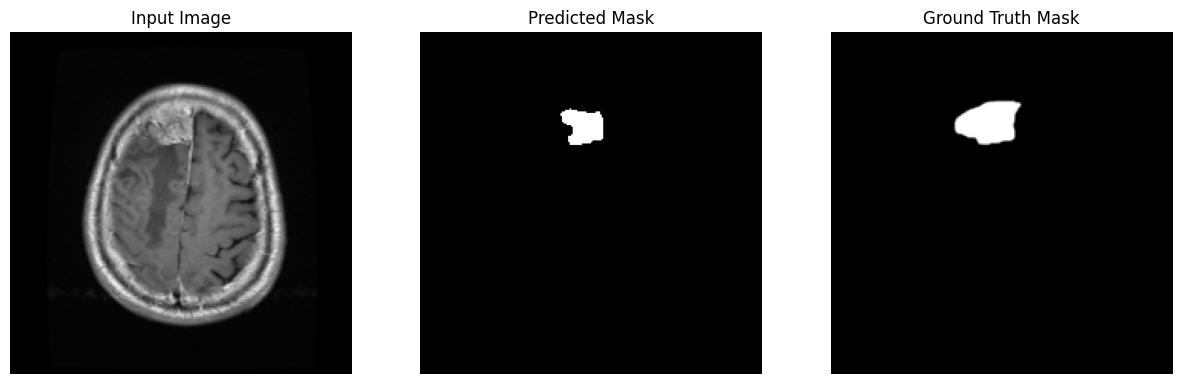

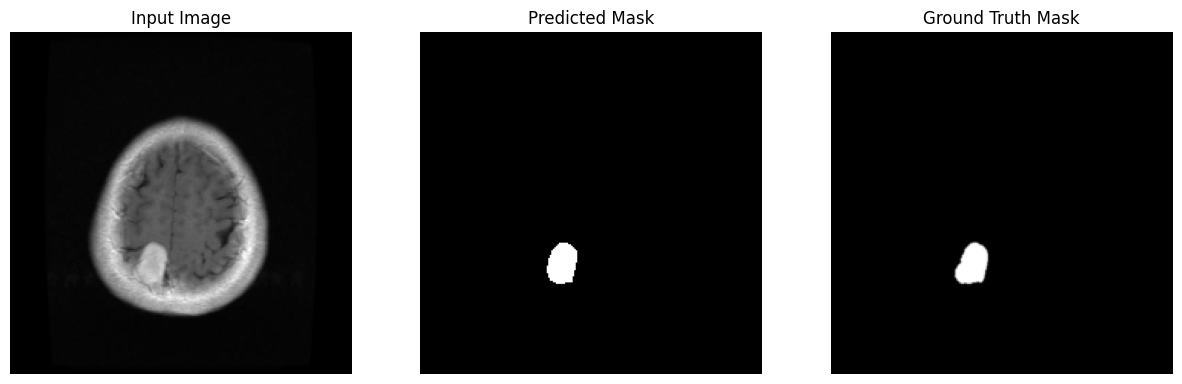

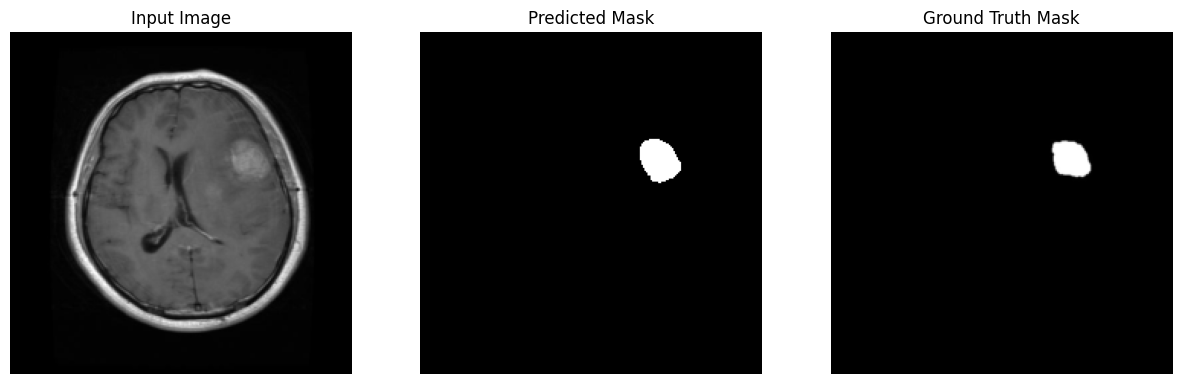

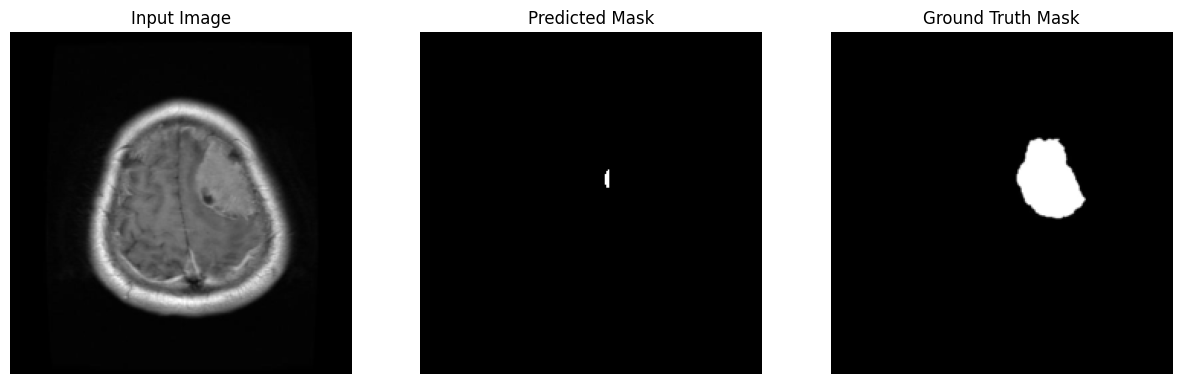

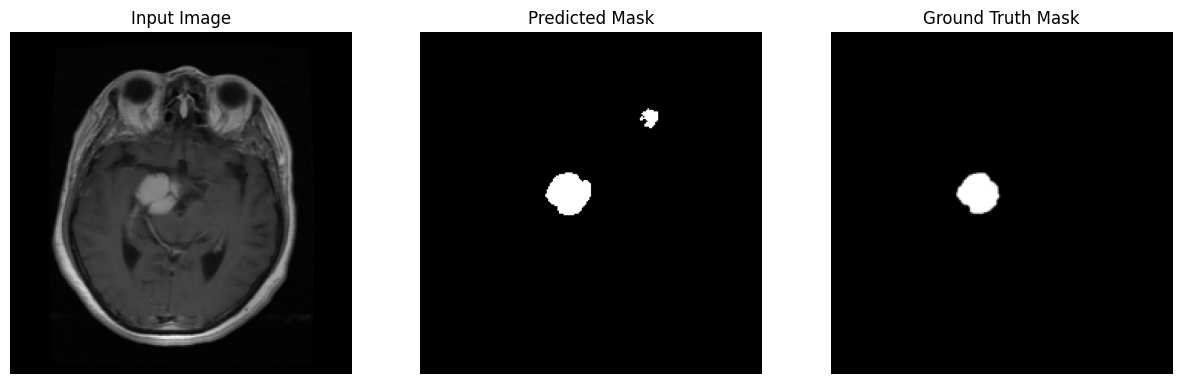

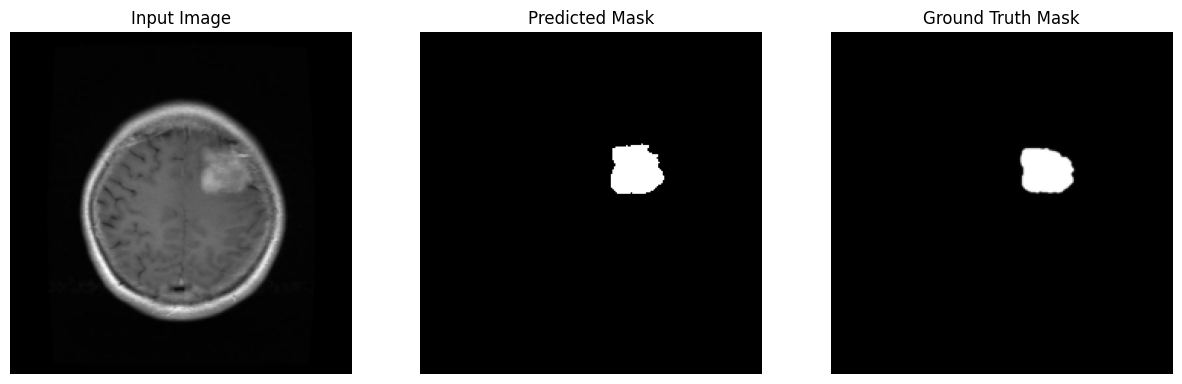

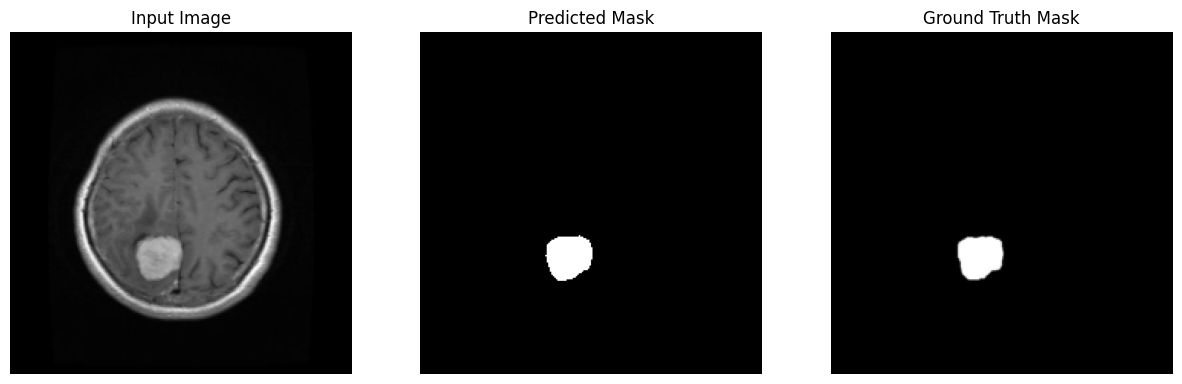

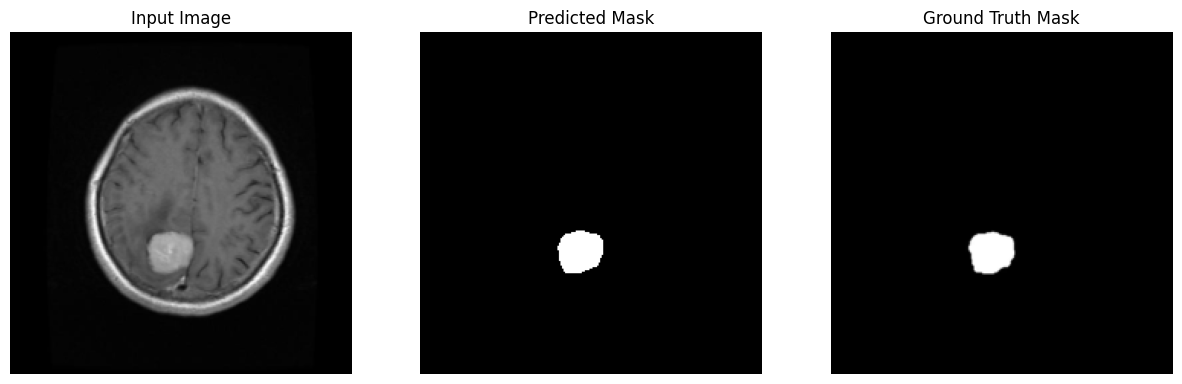

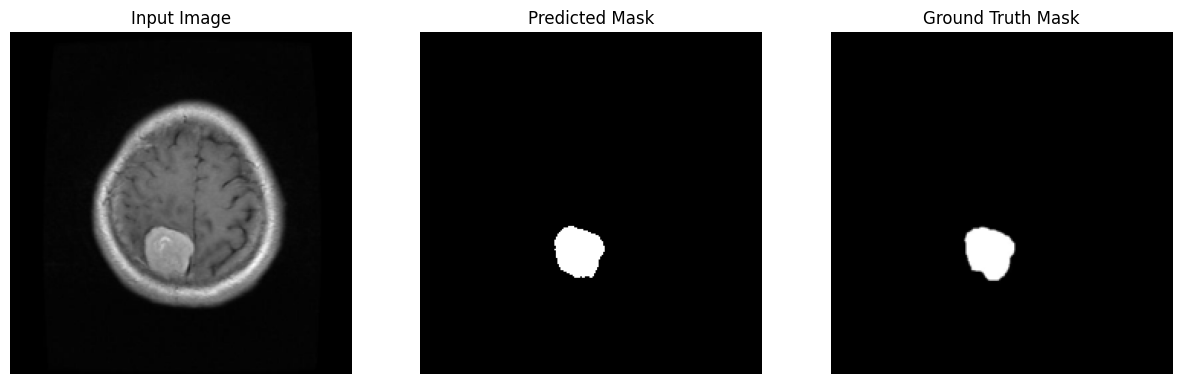

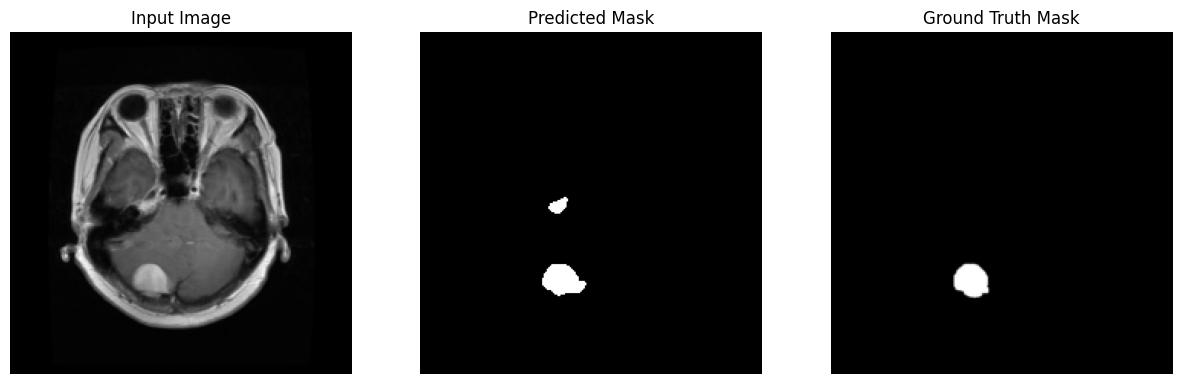

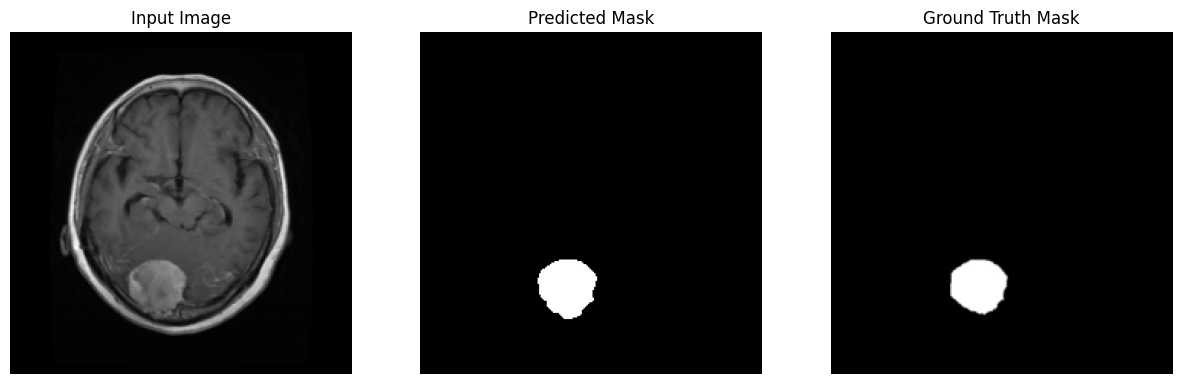

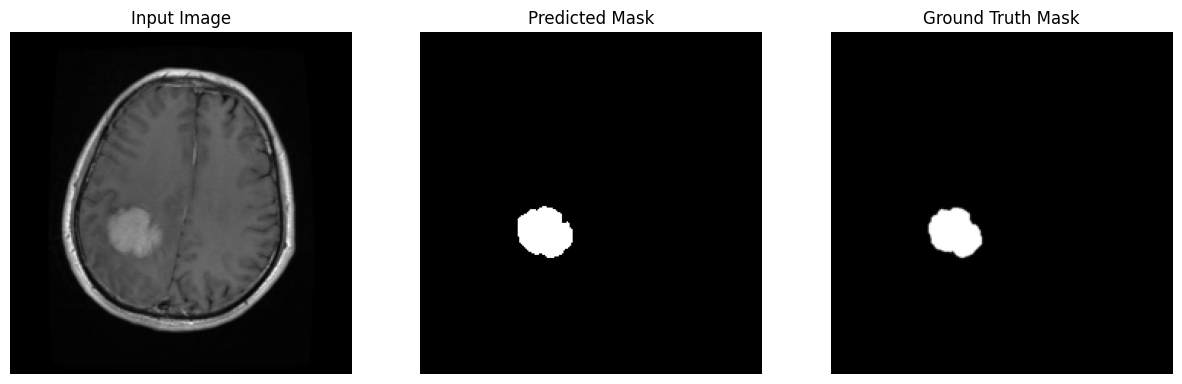

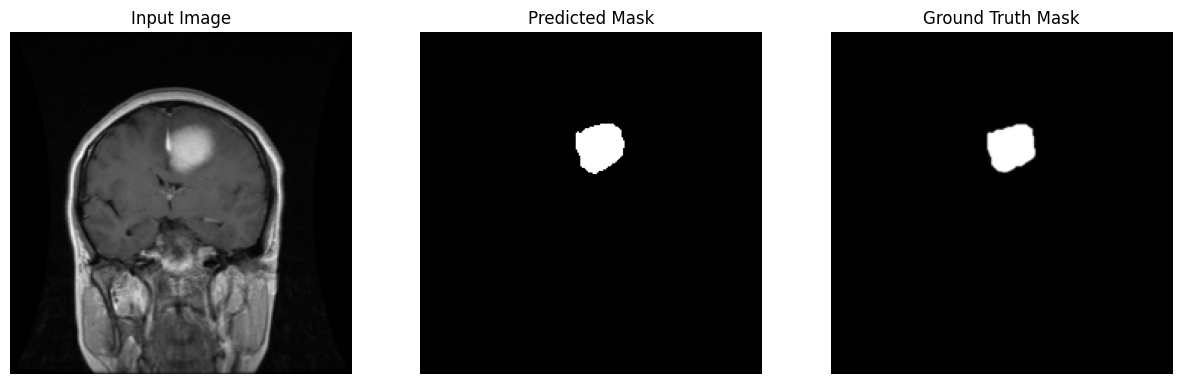

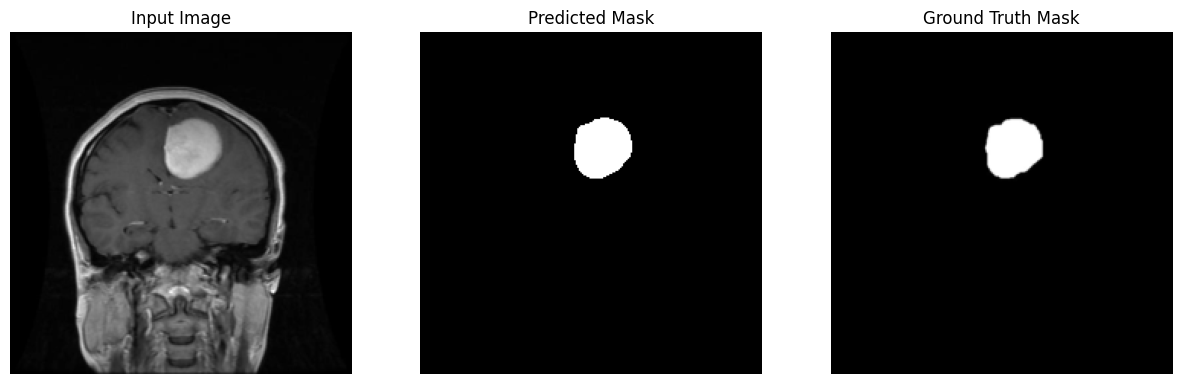

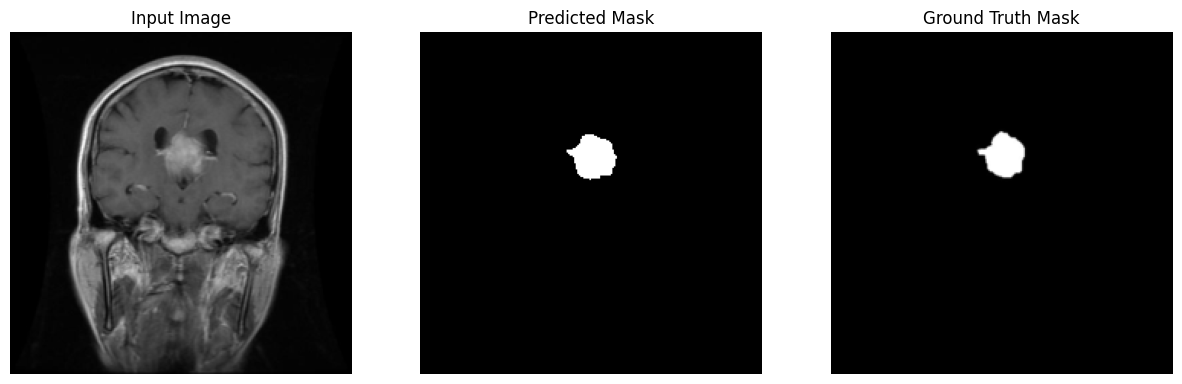

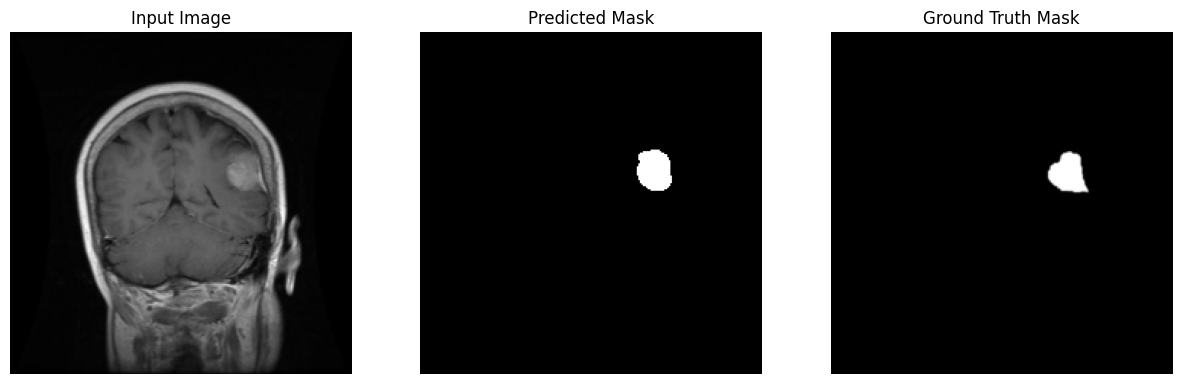

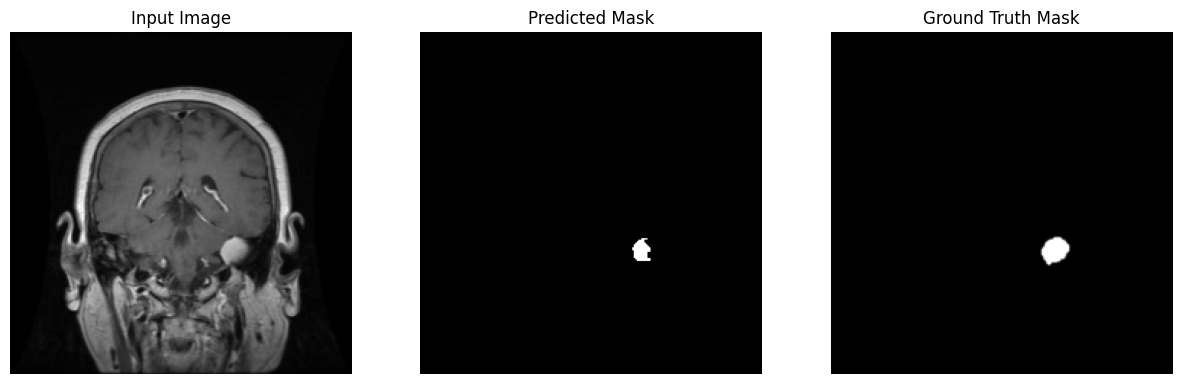

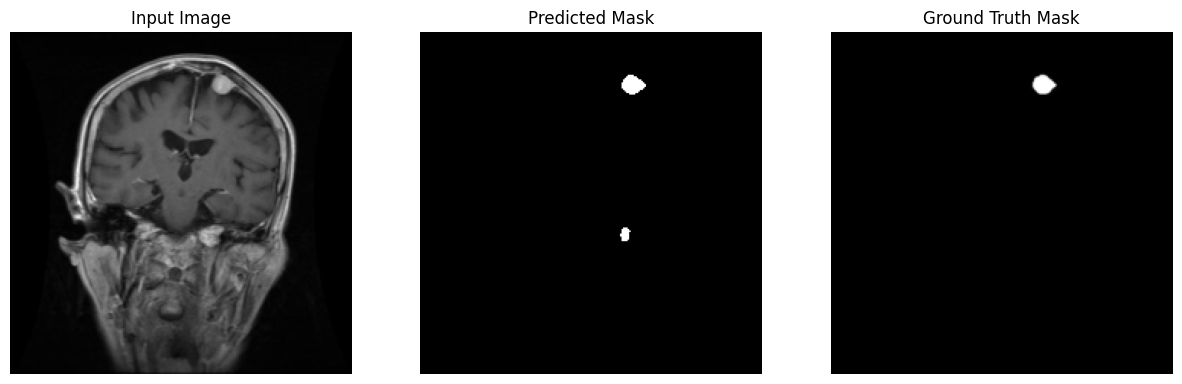

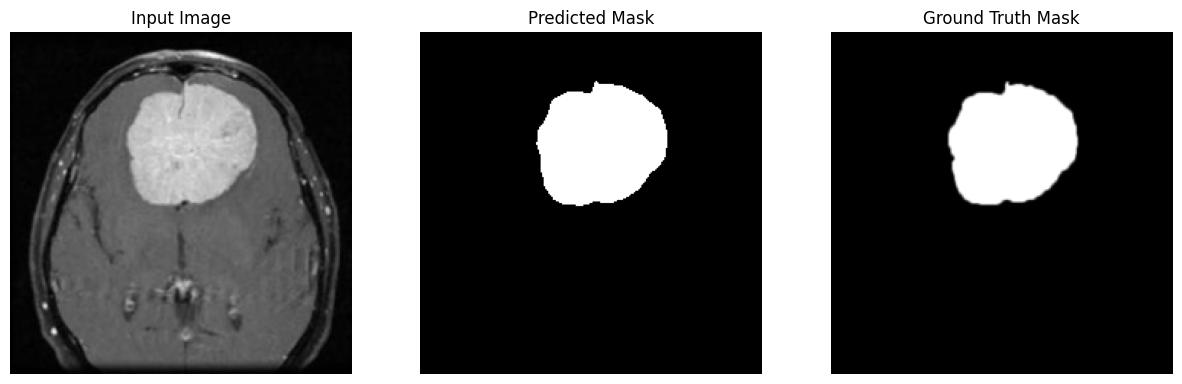

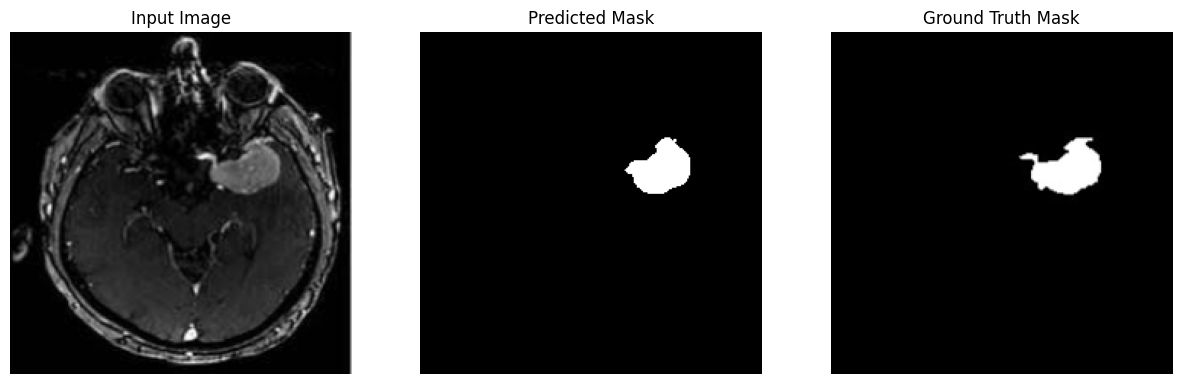

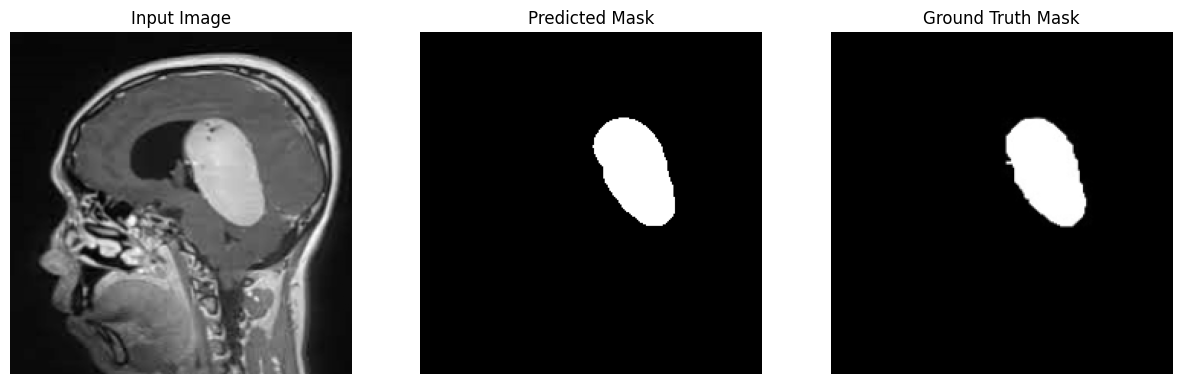

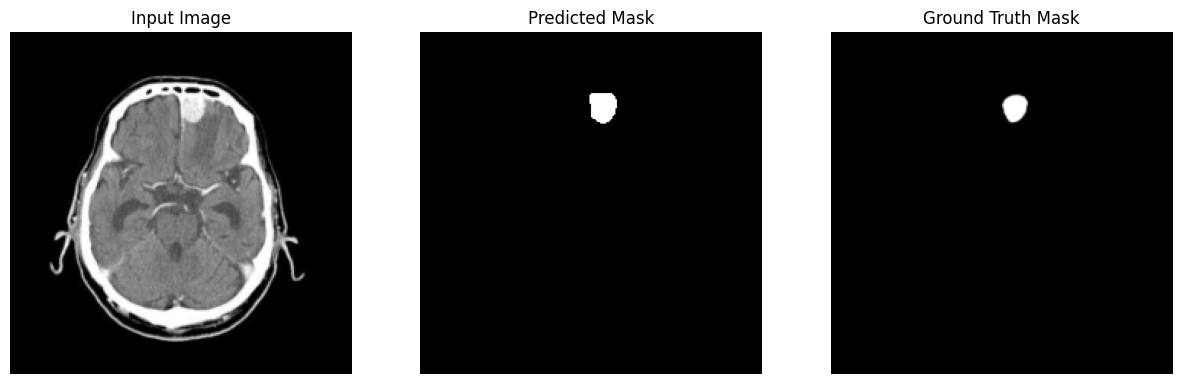

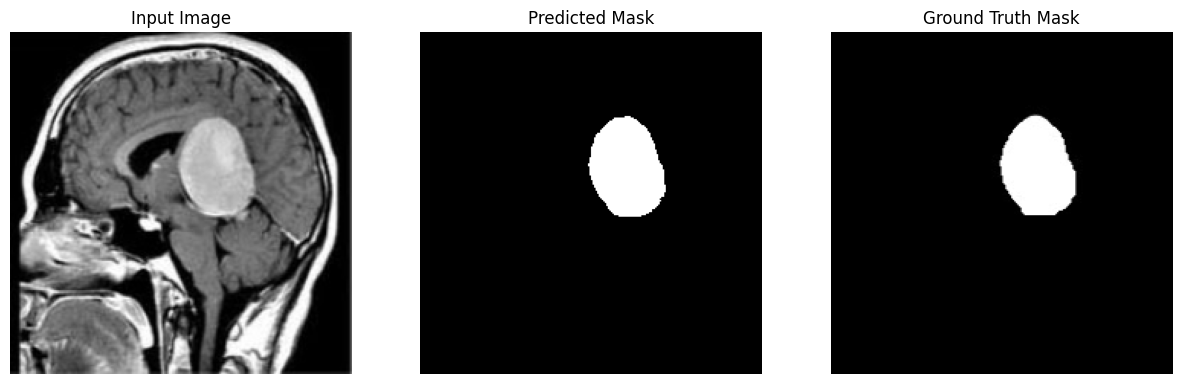

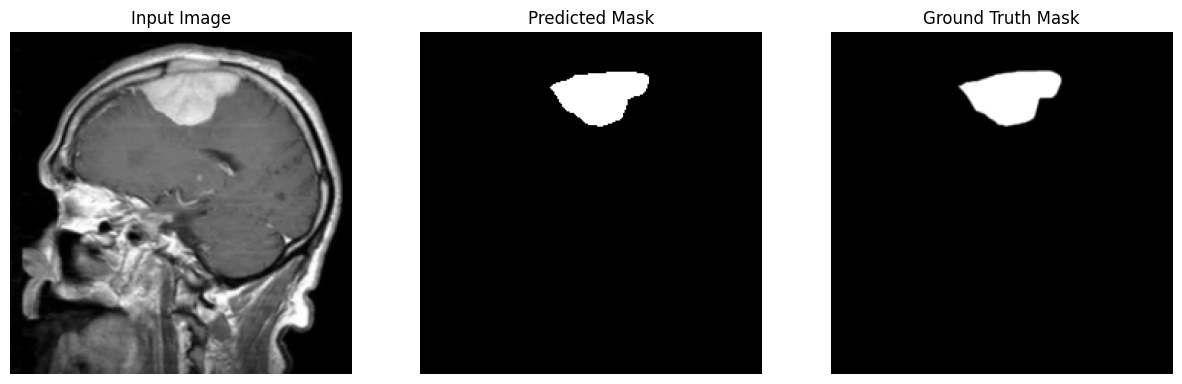

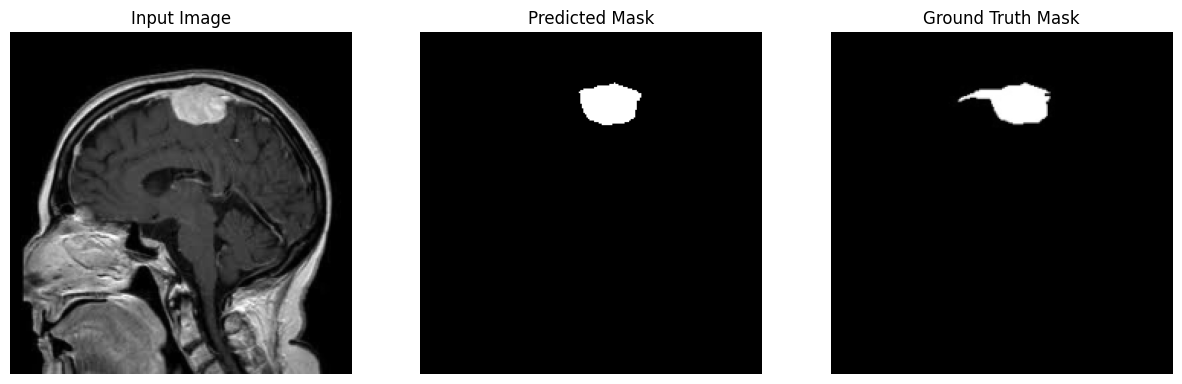

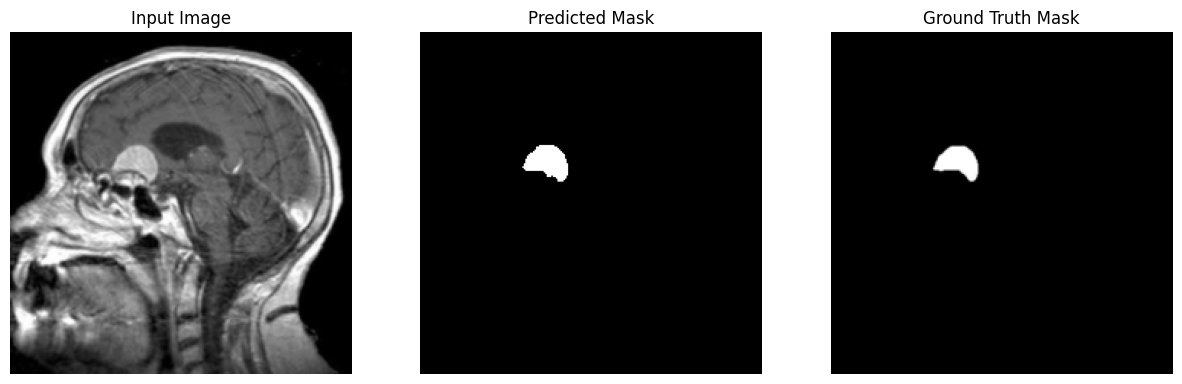

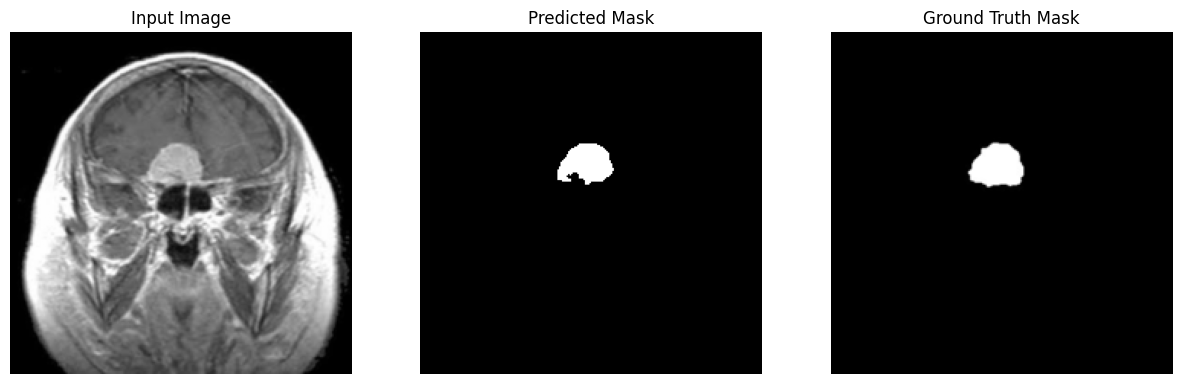

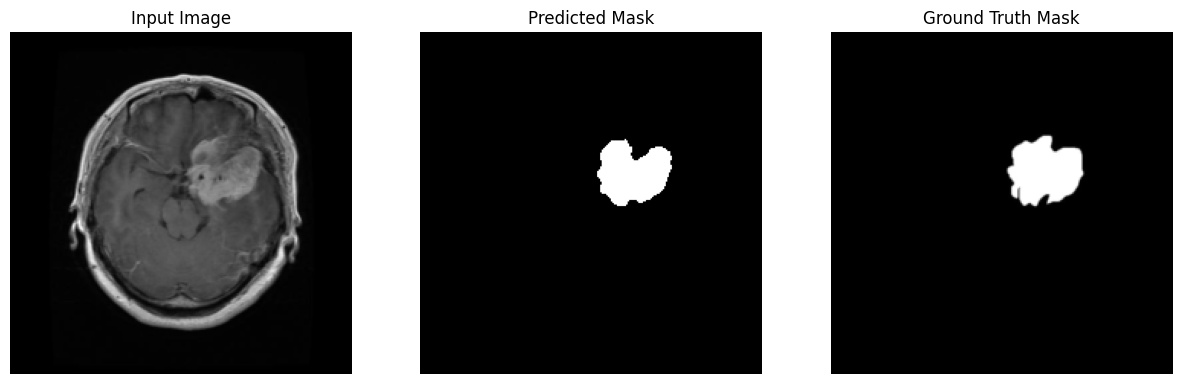

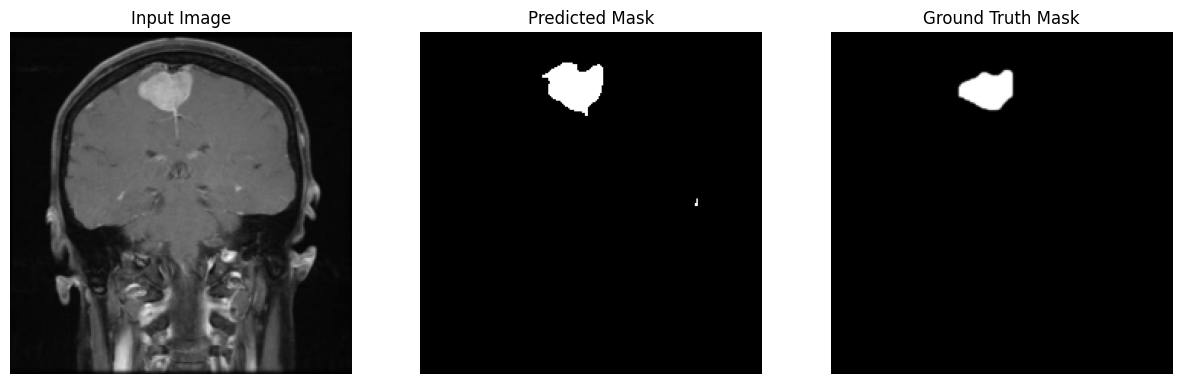

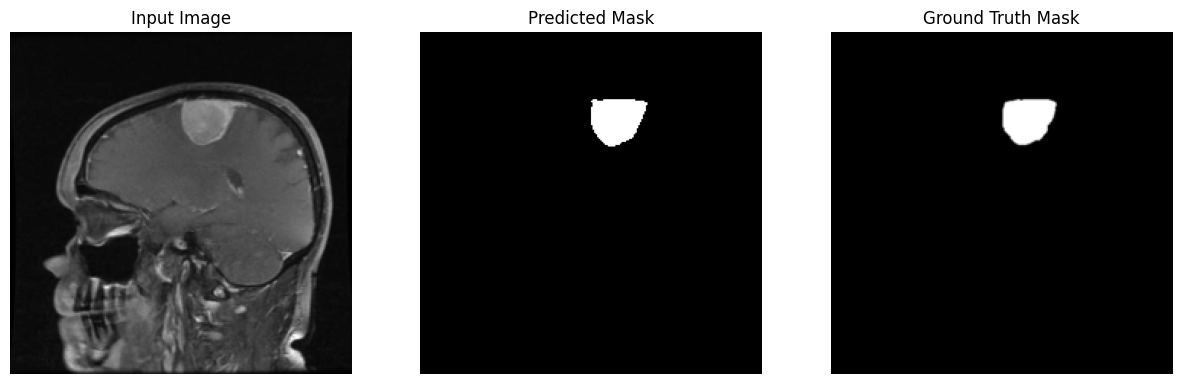

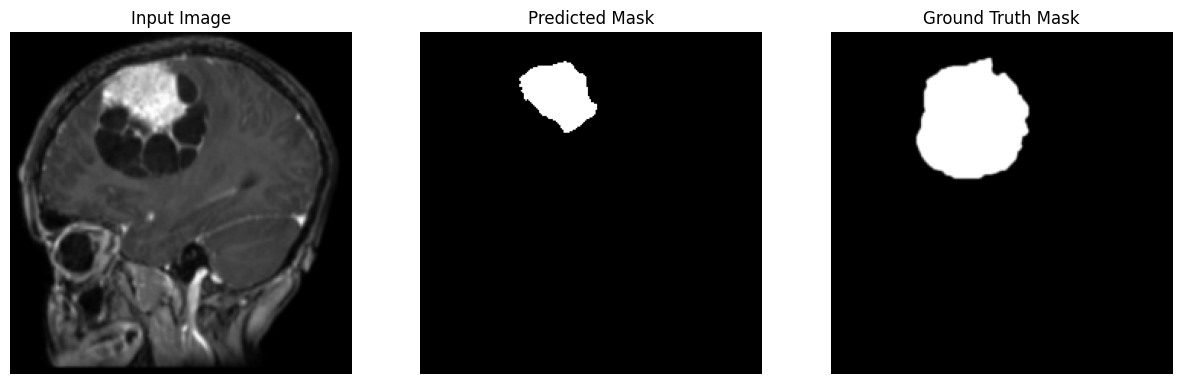

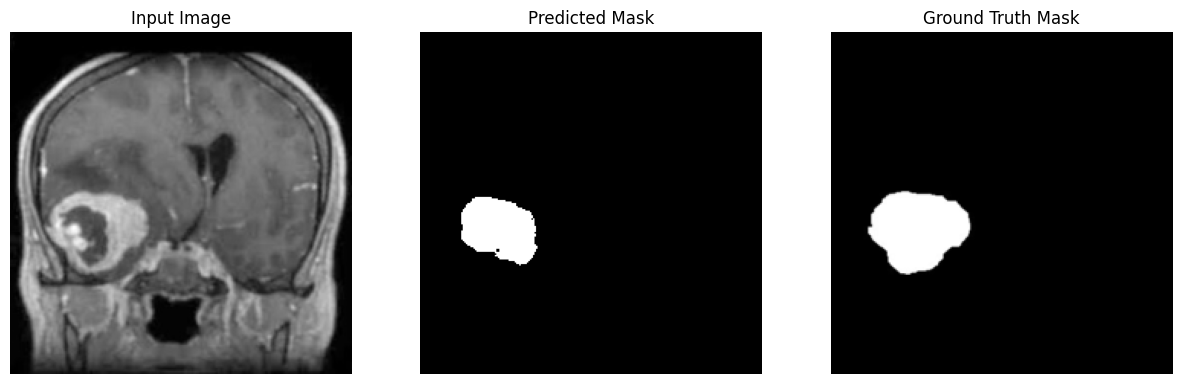

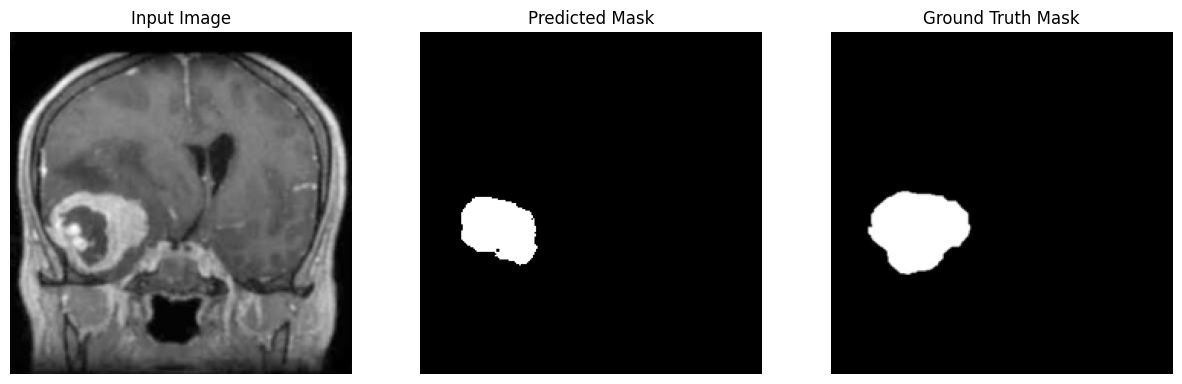

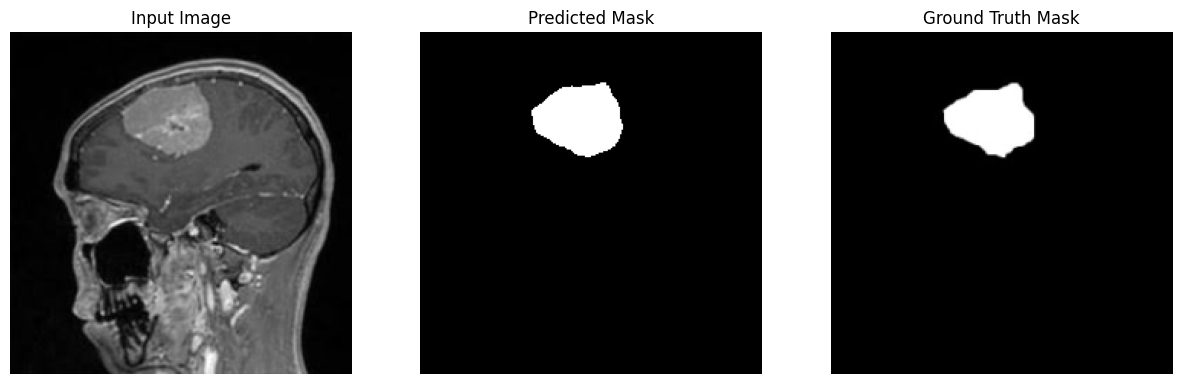

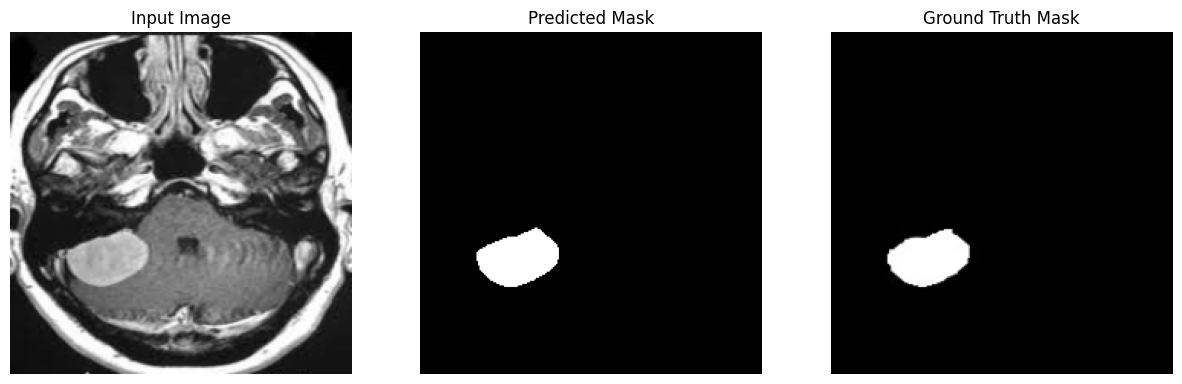

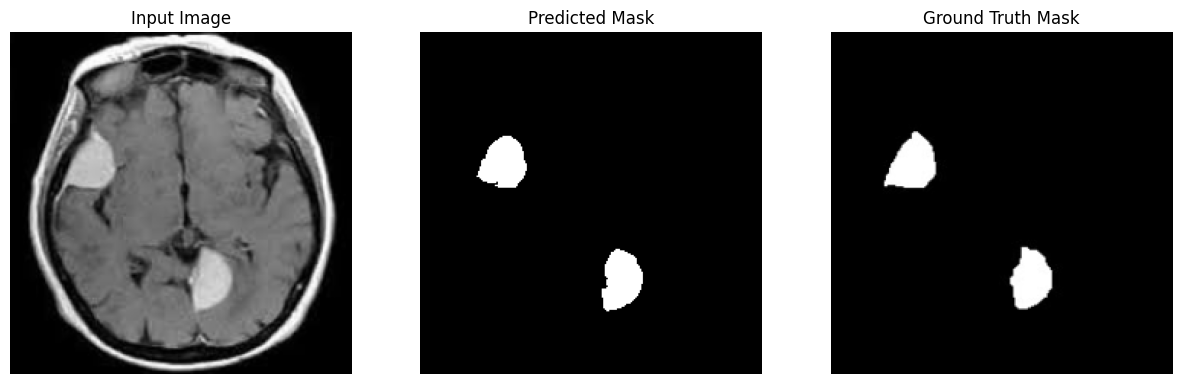

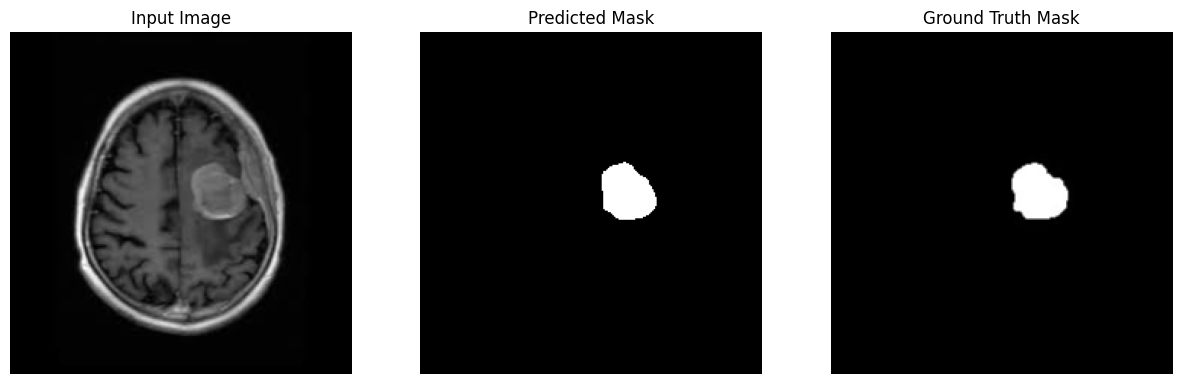

Average IoU: 0.8950
Test Loss: 0.0474, Test Dice Coefficient: 0.9217


In [124]:
# Inference phase using test_loader
model.eval()  # Set the model to evaluation mode
running_test_loss = 0.0
running_test_dice = 0.0
running_iou = 0.0

with torch.no_grad():  # No need to track gradients for inference
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate losses (Dice, BCE, etc.)
        diceloss = Diceloss(outputs, labels)
        bceloss = BCEloss(outputs, labels)
        tverskyloss = Tverskyloss(outputs, labels)
        
        total_loss = (1 * diceloss) + (0.1 * bceloss) + (0.15 * tverskyloss)     
        running_test_loss += total_loss.item()
        
        # Calculate Dice coefficient
        labels_bin = (labels > 0.5).int()
        outputs_bin = (outputs > 0.5).int()
        batch_test_dice = dice_coeff(outputs_bin, labels_bin)
        running_test_dice += batch_test_dice
        
        iou = calculate_iou(outputs_bin, labels_bin)
        running_iou += iou
        

        # Visualize the first few test images and predictions
        if i < 10:  # Display only a few samples for visualization
            predicted_mask = (outputs > 0.5).int()

            # Convert outputs to numpy arrays for visualization
            predicted_mask_np = predicted_mask.squeeze(1).cpu().numpy()
            ground_truth_np = labels.squeeze(1).cpu().numpy()
            inputs_np = inputs.squeeze(1).cpu().numpy()  # Assuming a single channel for input

            # Visualize the first image in the batch
            for j in range(inputs.shape[0]):  # Loop over the batch
                if j < 5:  # Display first 5 images and predictions
                    # Transpose the input image from (C, H, W) to (H, W, C)
                    input_image = inputs[j].permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) to (H, W, C)
                    predicted_mask_img = predicted_mask_np[j, :, :].astype(np.float32)  # Predicted mask
                    ground_truth_img = ground_truth_np[j, :, :].astype(np.float32)  # Ground truth mask

                    # Plot the input image, predicted mask, and ground truth mask
                    plt.figure(figsize=(15, 5))

                    plt.subplot(1, 3, 1)
                    plt.imshow(input_image, cmap='gray')
                    plt.title('Input Image')
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(predicted_mask_img, cmap='gray')
                    plt.title('Predicted Mask')
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(ground_truth_img, cmap='gray')
                    plt.title('Ground Truth Mask')
                    plt.axis('off')

                    plt.show()
                    

    # Calculate average test loss and dice score for the entire test set
    avg_test_loss = running_test_loss / len(test_loader)
    avg_test_dice = running_test_dice / len(test_loader)

    # Calculate average IoU for the entire test set
    avg_iou = running_iou / len(test_loader)  # Number of images processed
    print(f'Average IoU: {avg_iou:.4f}')

    print(f'Test Loss: {avg_test_loss:.4f}, Test Dice Coefficient: {avg_test_dice:.4f}')
